In [1]:
import numpy as np
np.random.seed(1337)  # for reproducibility

import tensorflow.keras as keras
from tensorflow.keras.utils import to_categorical

import matplotlib.pyplot as plt
import pickle

import utils as pic
    
%load_ext autoreload
%autoreload 2

In [2]:
lr_init     = 1.e-5    # Initial learning rate  
batch_size  = 100       # Training batch size
train_size  = 4000     # Training size
valid_size  = 1000     # Validation size
test_size   = 1000     # Test size
epochs      = 20       # Number of epochs
doGPU       = False    # Use GPU
tmin        = -0.1    # Minimum time cutoff
tmax        = 0.1     # Maximum time cutoff
tstep       = 0.0099   # Time steps

In [3]:
# Set range of training set
train_start, train_stop = 0, train_size
assert train_stop > train_start
assert (len(pic.decays)*train_size) % batch_size == 0
X_train, y_train = pic.load_data(train_start,train_stop)

# Set range of validation set
valid_start, valid_stop = 160000, 160000+valid_size
assert valid_stop  >  valid_start
assert valid_start >= train_stop
X_valid, y_valid = pic.load_data(valid_start,valid_stop)

# Set range of test set
test_start, test_stop = 204800, 204800+test_size
assert test_stop  >  test_start
assert test_start >= valid_stop
X_test, y_test = pic.load_data(test_start,test_stop)

samples_requested = len(pic.decays) * (train_size + valid_size + test_size)
samples_available = len(y_train) + len(y_valid) + len(y_test)
assert samples_requested == samples_available

In [4]:
X_e_train, X_t_train, maxframes, time_bins = pic.timeordered_BC(X_train, cumulative=True, min_t=tmin, max_t=tmax, t_step=tstep )
y_b_train = to_categorical(y_train)

In [5]:
X_e_valid, X_t_valid, maxframes, time_bins = pic.timeordered_BC(X_valid, cumulative=True, min_t=tmin, max_t=tmax, t_step=tstep )
y_b_valid = to_categorical(y_valid)


In [6]:
X_e_test, X_t_test, _, _ = pic.timeordered_BC(X_test, cumulative=True, min_t=tmin, max_t=tmax, t_step=tstep)
y_b_test = to_categorical(y_test)


In [15]:
modeldir = 'models/cnn3d-v2-1.00e-01-9.90e-03/'
# modeldir = 'models/crnn-1.00e-01-9.90e-03/'
model = keras.models.load_model(modeldir)
with open(f'{modeldir}/history.pkl','rb') as f_history: history = pickle.load(f_history)

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 21, 32, 32, 1)     0         
                                                                 
 conv3d (Conv3D)             (None, 21, 32, 32, 64)    1792      
                                                                 
 dropout (Dropout)           (None, 21, 32, 32, 64)    0         
                                                                 
 batch_normalization (BatchN  (None, 21, 32, 32, 64)   256       
 ormalization)                                                   
                                                                 
 max_pooling3d (MaxPooling3D  (None, 10, 16, 16, 64)   0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 10, 16, 16, 32)    5

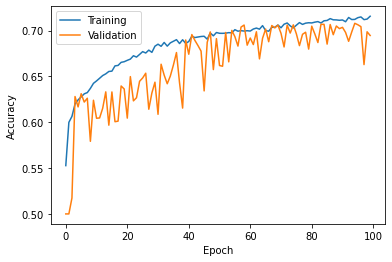

In [17]:
pic.plot_history(history,'accuracy')

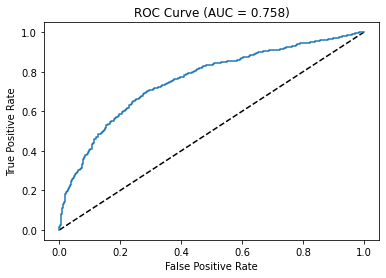

In [18]:
%matplotlib inline
pic.plot_roc(y_b_test[:,0], model.predict(X_e_test)[:,0])